## Import Library 

In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Dense, Activation, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix


## Constant

In [2]:
LABEL_NAMES = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
IMAGE_PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT
COLOR_CHANNELS = 3
TOTAL_INPUTS = IMAGE_PIXELS * COLOR_CHANNELS

## Gather the Data

In [3]:
(x_train_all, y_train_all), (x_test, y_test) = cifar10.load_data()

In [4]:
type(x_train_all)

numpy.ndarray

## Processing Data

In [5]:
x_train_all[0][0][0] #RGB

array([59, 62, 63], dtype=uint8)

In [6]:
x_train_all , x_test = x_train_all / 255.0, x_test /255.0

In [7]:
x_train_all.shape

(50000, 32, 32, 3)

In [8]:
y_train_cat = to_categorical(y_train_all, 10)
y_test_cat = to_categorical(y_test, 10)

In [9]:
y_train_cat.shape

(50000, 10)

## Build Model

In [11]:
def build_model(lr = 0, dc = 0, dr = 0):
    
    #add the 1st convolution layer to extract features from input image
    #feature map: 32*3*3 elu convoluted features
    #subsampling: pooling layer 2*2 pixel filter    
    #add a dropout layer with 20% dropout
    model = Sequential(name = 'CNN_cifar10')
    model.add(Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-4), padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    
    #create NN 256 neurons 1D vector and elu activation
    #add last layer 10 neurons using softmax function 
    model.add(Flatten())
    model.add(Dense(256, activation='elu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(dr))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = optimizers.Adam(lr = lr, decay = dc)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [12]:
model = build_model(lr = 0.001, dc = 1e-5, dr = 0.5)

In [13]:
model.summary()

Model: "CNN_cifar10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        

In [14]:
#data augmentation
datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, vertical_flip=False)
datagen.fit(x_train_all)

## Fit the Model

In [15]:
# run model
model.fit_generator(datagen.flow(x_train_all, y_train_cat, batch_size = 64),validation_data = (x_test, y_test_cat),
                                 steps_per_epoch = x_train_all.shape[0] // 64, epochs = 40, verbose = 1)

C:\Users\Admin\ana3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
781/781 [==============================] - 1400s 2s/step - loss: 2.2080 - accuracy: 0.3357 - val_loss: 1.4139 - val_accuracy: 0.5276

Epoch 00001: val_accuracy improved from -inf to 0.52760, saving model to cnn_best_model.h5
Epoch 2/40
781/781 [==============================] - 1356s 2s/step - loss: 1.3749 - accuracy: 0.5380 - val_loss: 1.1884 - val_accuracy: 0.6208

Epoch 00002: val_accuracy improved from 0.52760 to 0.62080, saving model to cnn_best_model.h5
Epoch 3/40
781/781 [==============================] - 1380s 2s/step - loss: 1.2005 - accuracy: 0.6074 - val_loss: 1.1608 - val_accuracy: 0.6388

Epoch 00003: val_accuracy improved from 0.62080 to 0.63880, saving model to cnn_best_model.h5
Epoch 4/40
781/781 [==============================] - 2203s 3s/step - loss: 1.0841 - accuracy: 0.6525 - val_loss: 0.9892 - val_accuracy: 0.6936

Epoch 00004: val_accuracy improved from 0.63880 to 0.69360, saving model to cnn_best_model.h5
Epoch 5/40
781/781 [===========================


Epoch 00038: val_accuracy did not improve from 0.86440
Epoch 39/40
781/781 [==============================] - 1827s 2s/step - loss: 0.5528 - accuracy: 0.8596 - val_loss: 0.5440 - val_accuracy: 0.8655

Epoch 00039: val_accuracy improved from 0.86440 to 0.86550, saving model to cnn_best_model.h5
Epoch 40/40
781/781 [==============================] - 1766s 2s/step - loss: 0.5488 - accuracy: 0.8571 - val_loss: 0.5429 - val_accuracy: 0.8665

Epoch 00040: val_accuracy improved from 0.86550 to 0.86650, saving model to cnn_best_model.h5


## Evaluation

In [16]:
def plot_model(history): 
    fig, axs = plt.subplots(1,2,figsize=(16,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'], 'c') 
    axs[0].plot(history.history['val_accuracy'],'m') 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'], 'c') 
    axs[1].plot(history.history['val_loss'], 'm') 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper right')
    plt.show()

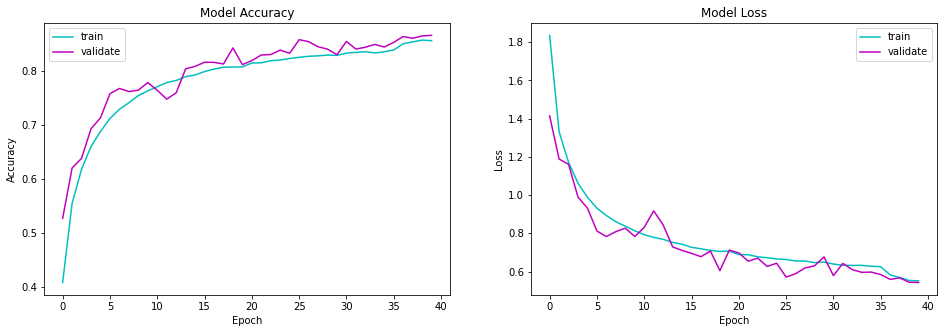

In [17]:
plot_model(model.history)

In [18]:
saved_model = load_model('cnn_best_model.h5')
test_loss, test_acc = saved_model.evaluate(x_test, y_test_cat, verbose=0)
print('Test Accuracy:', round(test_acc, 2))

Test Accuracy: 0.87


In [20]:
predictions = saved_model.predict_classes(x_test, verbose=0)

### Confusion Matrix

In [23]:
conf_matrix = confusion_matrix(y_true = y_test, y_pred = predictions)

In [24]:
conf_matrix

array([[901,   9,  29,   5,   4,   0,   8,   4,  21,  19],
       [  3, 967,   0,   0,   0,   0,   3,   0,   2,  25],
       [ 30,   1, 844,   9,  32,  11,  56,  12,   1,   4],
       [ 18,   4,  50, 670,  42,  52,  94,  44,  11,  15],
       [  6,   1,  34,  10, 871,   3,  48,  26,   0,   1],
       [ 11,   2,  36,  92,  40, 705,  53,  52,   2,   7],
       [  3,   1,  18,   4,   9,   0, 960,   3,   0,   2],
       [ 14,   1,  21,  10,  21,   6,  16, 907,   1,   3],
       [ 50,  15,   4,   1,   0,   0,  11,   1, 896,  22],
       [ 12,  36,   2,   2,   1,   0,   0,   0,   3, 944]], dtype=int64)

In [27]:
nr_rows = conf_matrix.shape[0]
nr_cols = conf_matrix.shape[1]

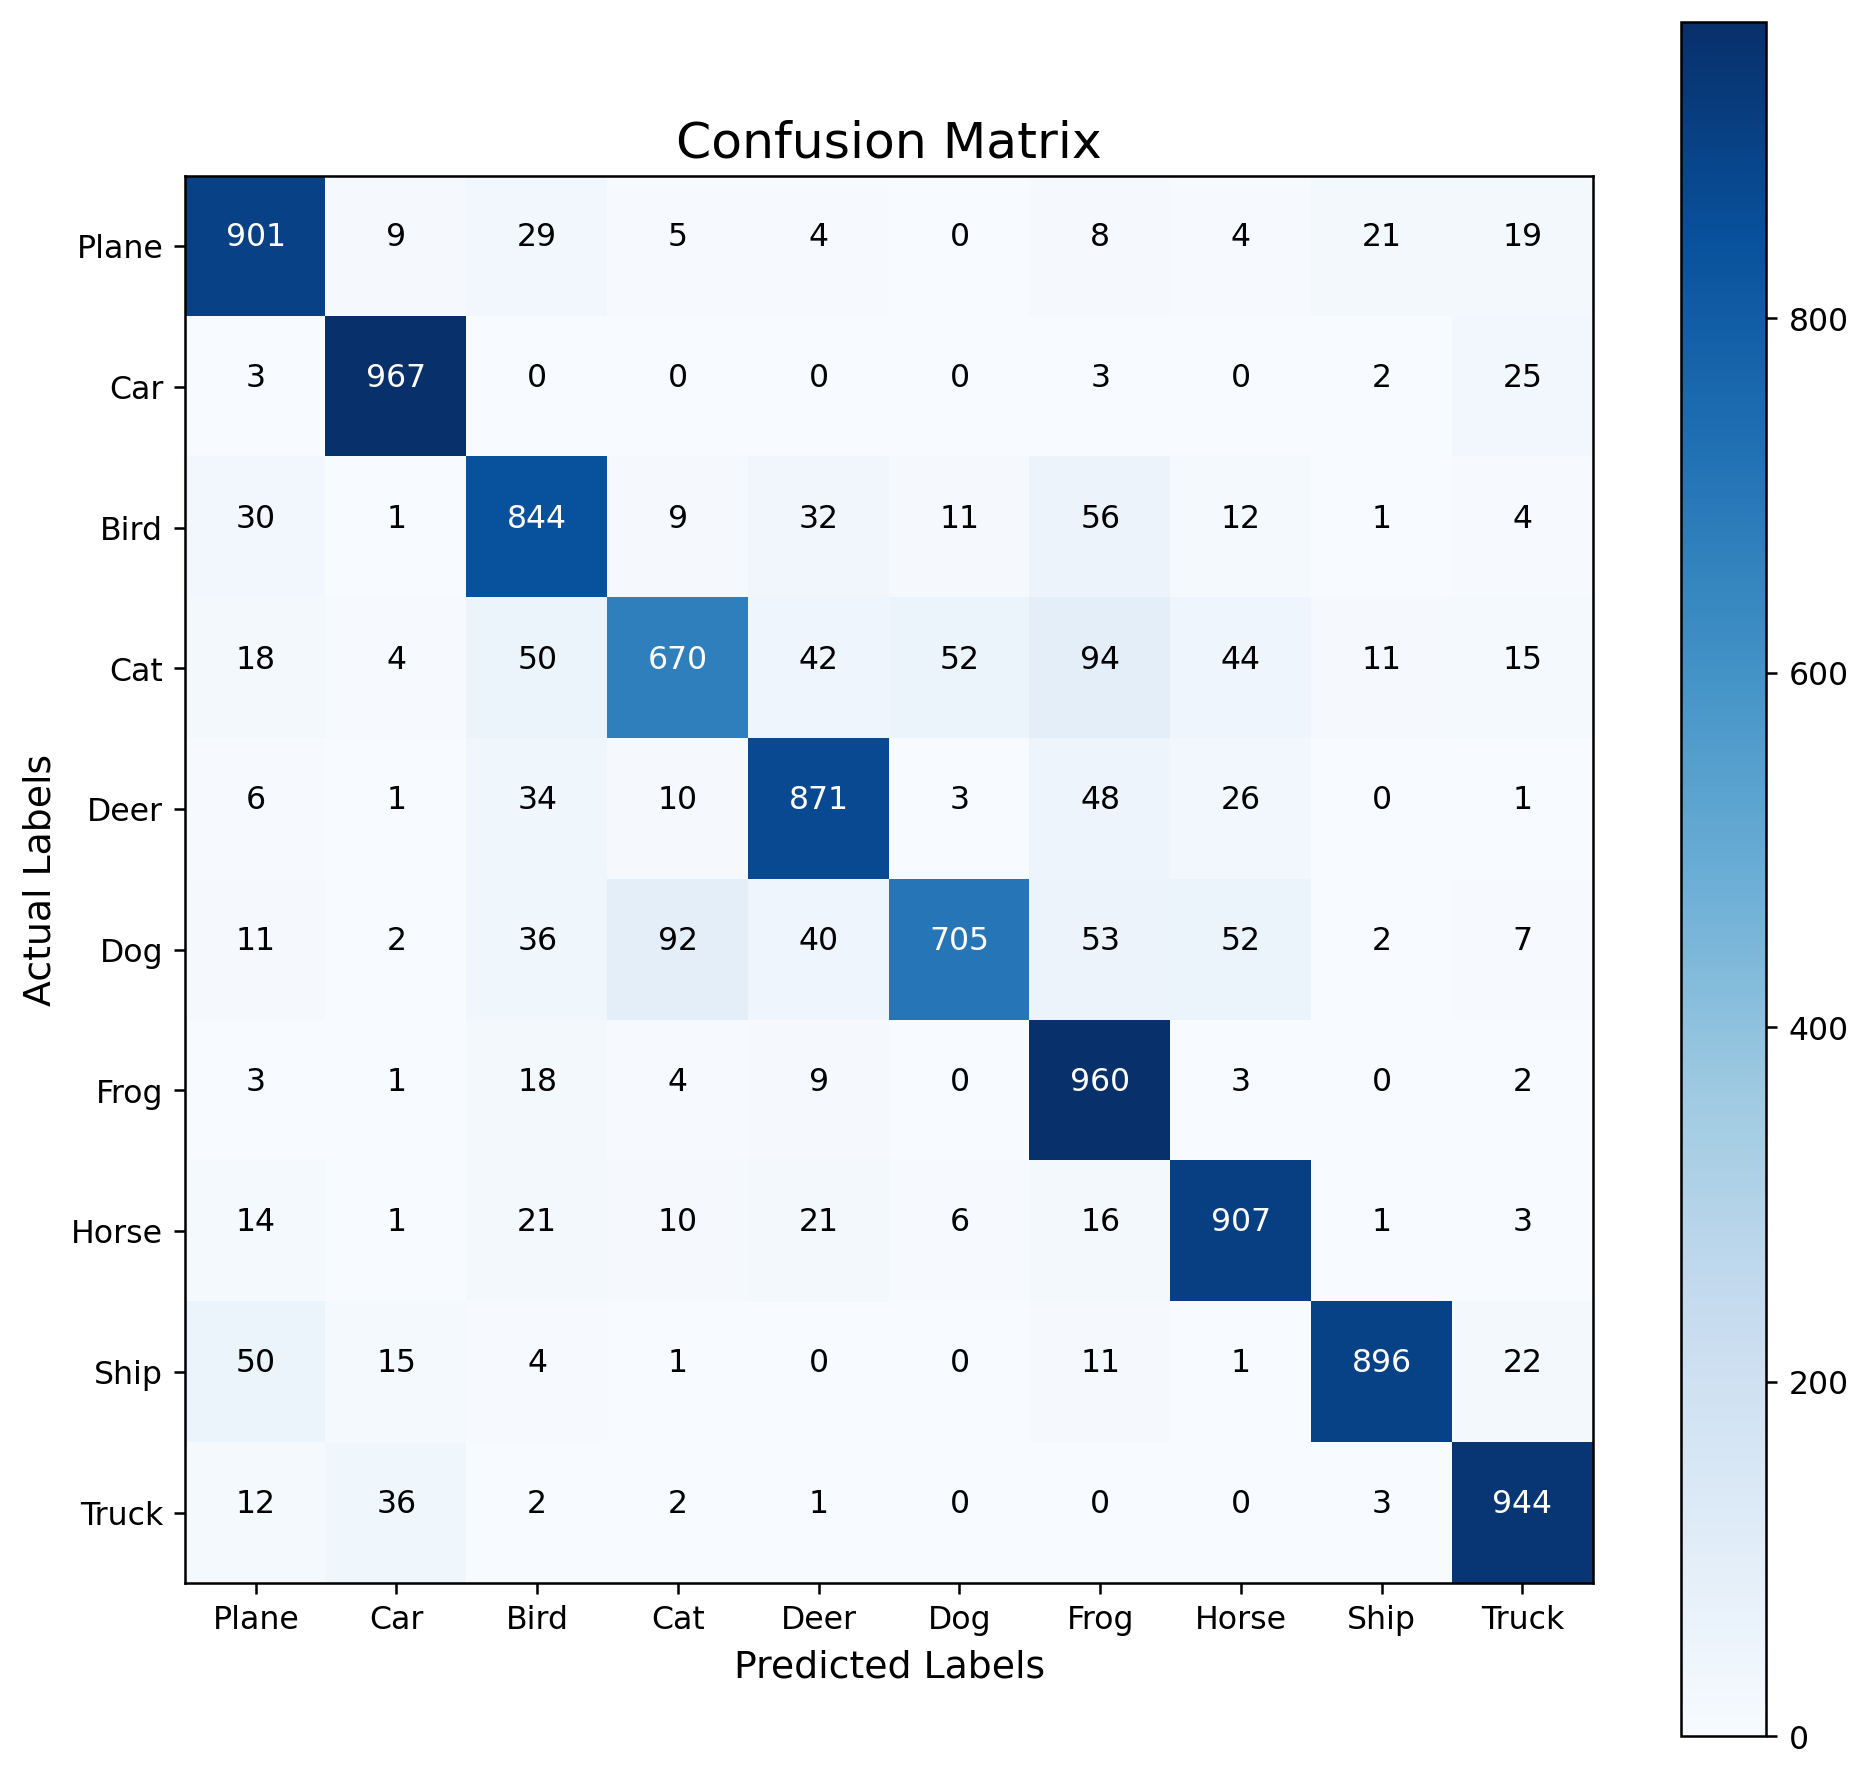

In [29]:
plt.figure(figsize=(10,10), dpi=227)
plt.imshow(conf_matrix, cmap=plt.cm.Blues)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Labels', fontsize=12)
plt.xlabel('Predicted Labels', fontsize=12)


tick_marks = np.arange(10)
plt.yticks(tick_marks, LABEL_NAMES)
plt.xticks(tick_marks, LABEL_NAMES)
plt.colorbar()

for i, j in itertools.product(range(nr_rows), range(nr_cols)):
    plt.text(j, i, conf_matrix[i, j], horizontalalignment= 'center', color='white' if conf_matrix[i,j] > conf_matrix.max()/2 else 'black')
    
plt.show()

In [30]:
# True Positives
np.diag(conf_matrix)

array([901, 967, 844, 670, 871, 705, 960, 907, 896, 944], dtype=int64)

In [31]:
recall_score = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
recall_score

array([0.901, 0.967, 0.844, 0.67 , 0.871, 0.705, 0.96 , 0.907, 0.896,
       0.944])

In [32]:
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
precision

array([0.85973282, 0.93249759, 0.81310212, 0.83437111, 0.85392157,
       0.90733591, 0.76861489, 0.86463298, 0.95624333, 0.9059501 ])

In [38]:
avg_recall_score = np.mean(recall_score)
print(f'Model recall score is {avg_recall_score:0.2%}')

Model recall score is 86.65%


In [39]:
avg_precision = np.mean(precision)
print(f'Model precision score is {avg_precision:0.2%}')

f1_score = 2 * (avg_precision * avg_recall_score) / (avg_precision + avg_recall_score)
print(f'Model f score is {f1_score:.2%}')

Model precision score is 86.96%
Model f score is 86.81%
